In [1]:
using FunctionalCollections
using Iterators
using Pipe
using Compat

macro printval(ee)
    ee_expr = @sprintf "%s" string(ee)
    esc(:(println($ee_expr," = ", $ee)))
end

macro pz(ee)
    ee_expr = @sprintf "%s" string(ee)
    esc(:(println($ee_expr,"\t\t",typeof($ee), "\t", size($ee))))
end

push!(LOAD_PATH, ".")
push!(LOAD_PATH, "../util/")
using DataStructures
using DataStructuresExtended
using JLD
using DataFrames

In [2]:
function groupby_value(fn::Function, xs)
    key_type = typeof(fn(first(xs)))
    group_type = Vector{typeof(first(xs))}
    groups = Dict{key_type, group_type}()
    
    for x in xs
        key = fn(x)
        group = get!(()->group_type(), groups, key)
        push!(group, x)
    end
    groups
end
function round_tbl(data::DataFrame, places=2)
    ret = copy(data)
    for (ii,column) in enumerate(ret.columns)
        if typeof(column[1])<:Number #hack
            ret.columns[ii] = round(column, places)
        end
    end
    ret
end


round_tbl (generic function with 2 methods)

In [3]:
OUTPUT_DIR = "../../documents_prepared/Journal\ Papers/SumResynthesis/data/"

"../../documents_prepared/Journal Papers/SumResynthesis/data/"

In [4]:
function jaccard_index(aa::DataStructures.Accumulator,bb::DataStructures.Accumulator)
    sum(intersect(aa,bb))/sum(union(aa,bb))
end

function jaccard_index(aa,bb)
    length(intersect(aa,bb))/length(union(aa,bb))
end

jaccard_index (generic function with 2 methods)

In [30]:
function precision(actual::DataStructures.Accumulator,reference::DataStructures.Accumulator)
    sum(intersect(actual,reference))/sum(actual)
end
function recall(actual::DataStructures.Accumulator,reference::DataStructures.Accumulator)
    sum(intersect(actual,reference))/sum(reference)
end

function f1_score(actual::DataStructures.Accumulator,reference::DataStructures.Accumulator)
    prec = precision(actual,reference)
    rec = recall(actual,reference)
    2*prec*rec/(prec+rec)
end

f1_score (generic function with 1 method)

In [6]:
function flatten_blocked_records{T<:Number, V}(records::Dict{T,V})  
    rec_types = @pipe records |> values |> map(typeof,_) |> union
    rec_type = length(rec_types)==1 ? rec_types[1] : V
    ret = rec_type() #Construct it, it is some form of vector, or we will error soon
    sizehint!(ret) = sum([length(r) for r in values(records)])
    
    sorted_keys = @pipe records |> keys |> collect |> sort
    for key in sorted_keys
        push!(ret, records[key]...)
    end
    ret
end

function flatten_raw_blocked_records{T,V}(records::Dict{T,V})  
    key_types = @pipe records |> keys|> map(parse,_) |> map(typeof,_) |> union
    @assert length(key_types)==1
    key_type =  key_types[1]
    
    rec_types = @pipe records |> values |> map(typeof,_) |> union
    rec_type = length(rec_types)==1 ? rec_types[1] : V
    flatten_blocked_records(Dict(Pair{key_type, rec_type}[parse(k)=>v for (k,v) in records]))
end

flatten_raw_blocked_records (generic function with 1 method)

In [42]:

#books_glove300cityblock_raw = load("results/bags/books_corpus_0.001_of_test_glove300_cityblock.jld","4")
books_0_01_glove300_raw = flatten_raw_blocked_records(load("results/bags/books_corpus_0.01_of_test.jld"))
#books_001o_glove300_raw = flatten_raw_blocked_records(load("results/bags/books_corpus_0.01_of_test_glove300.jld"))
brown_glove300_raw = load("results/bags/brown_glove300_res.jld", "res")
brown_glove200_raw = load("results/bags/brown_glove200_res.jld", "res")
brown_glove100_raw = load("results/bags/brown_glove100_res.jld", "res")
brown_glove50_raw = load("results/bags/brown_glove50_res.jld", "res")

42004-element Array{Any,1}:
 (ASCIIString["``","only","a","relative","handful","of","such","reports","was","received"  …  "of","voters","and","the","size","of","this","city","''","."],ASCIIString["that","that","that","that","that","that","that","it","that","of"  …  "marginal","marc","thereon","gunning","ledford","market-place","included","on","than","as"],-2.6416790753173873)                               
 (ASCIIString["it","recommended","that","fulton","legislators","act","``","to","have","these"  …  "to","the","end","of","modernizing","and","improving","them","''","."],ASCIIString["we","not","not","government","it","its","law","these","to","in"  …  "revised","jenks","selma","recurrent","reuben","tracked","should","there","symbolically","working"],-3.467678697624857)            
 (ASCIIString["the","grand","jury","commented","on","a","number","of","other","topics"  …  "inure","to","the","best","interest","of","both","governments","''","."],ASCIIString["they","have","have","they","tha

In [43]:
@assert all([rset[1] for rset in brown_glove50_raw] .== [rset[1] for rset in brown_glove300_raw])
@assert all([rset[1] for rset in brown_glove50_raw] .== [rset[1] for rset in brown_glove200_raw])
@assert all([rset[1] for rset in brown_glove50_raw] .== [rset[1] for rset in brown_glove100_raw])

In [ ]:
Mean

66464

In [75]:
bag_res = DataFrame()
bag_res[:ground] = [counter(rset[1]) for rset in brown_glove50_raw]# books_0_01_glove300_raw]
bag_res[:ground_len] = Int[sum(ss) for ss in bag_res[:ground]]
exp_names = ASCIIString[]
for raw_name in ["brown_glove50_raw","brown_glove100_raw", "brown_glove200_raw", "brown_glove300_raw"]#
#for raw_name in ["books_0_01_glove300_raw"]
    colname = join(split(raw_name,"_")[1:end-1],"_")
    push!(exp_names, colname)
    raw = eval(raw_name|>Symbol)
    bag_res[colname*"_actual"|> Symbol] = [counter(rset[2]) for rset in raw]
    #bag_res[colname*"_distance"|> Symbol] = Float64[-1*rset[3] for rset in raw]
end

#bag_res

In [76]:
for exp_name in exp_names
    actual = bag_res[exp_name*"_actual" |> symbol]
    bag_res[exp_name*"_perfect" |> symbol] = actual.==bag_res[:ground]
    bag_res[exp_name*"_jaccard" |> symbol] = map(jaccard_index, actual, bag_res[:ground])
    bag_res[exp_name*"_precision" |> symbol] = map(precision, actual, bag_res[:ground])
    bag_res[exp_name*"_recall" |> symbol] = map(recall, actual, bag_res[:ground])
    bag_res[exp_name*"_f1" |> symbol] = map(f1_score, actual, bag_res[:ground])
end

In [77]:
keep_cols = @pipe (bag_res.colindex |> keys |> map(string,_)
                    |>filter(col -> contains(col,"jaccard") 
                                ||  contains(col,"perfect") 
                                ||  contains(col,"recall")
                                ||  contains(col,"_precision")
                                ||  contains(col,"f1" ),_)
                    |> map(Symbol,_))
len_scores = aggregate(bag_res[[:ground_len, keep_cols...]], :ground_len, mean)
sort!(len_scores)
writetable(OUTPUT_DIR*"selection_len_scores.csv", len_scores)
len_scores |> round_tbl

,ground_len,brown_glove50_perfect_mean,brown_glove50_jaccard_mean,brown_glove50_precision_mean,brown_glove50_recall_mean,brown_glove50_f1_mean,brown_glove100_perfect_mean,brown_glove100_jaccard_mean,brown_glove100_precision_mean,brown_glove100_recall_mean,brown_glove100_f1_mean,brown_glove200_perfect_mean,brown_glove200_jaccard_mean,brown_glove200_precision_mean,brown_glove200_recall_mean,brown_glove200_f1_mean,brown_glove300_perfect_mean,brown_glove300_jaccard_mean,brown_glove300_precision_mean,brown_glove300_recall_mean,brown_glove300_f1_mean
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2,0.92,0.93,0.93,0.93,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,3,0.68,0.73,0.76,0.77,NaN,0.98,0.98,0.98,0.98,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4,0.41,0.52,0.58,0.61,NaN,0.94,0.96,0.97,0.97,NaN,0.99,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,5,0.28,0.42,0.48,0.52,NaN,0.86,0.91,0.92,0.94,NaN,0.98,0.99,0.99,0.99,0.99,1.0,1.0,1.0,1.0,1.0
6,6,0.12,0.27,0.34,0.39,NaN,0.75,0.85,0.87,0.9,NaN,0.97,0.98,0.99,0.99,0.99,0.99,0.99,1.0,1.0,1.0
7,7,0.05,0.2,0.27,0.33,NaN,0.65,0.78,0.81,0.85,NaN,0.96,0.98,0.99,0.99,0.99,0.99,1.0,1.0,1.0,1.0
8,8,0.02,0.17,0.24,0.29,NaN,0.5,0.68,0.73,0.78,NaN,0.95,0.98,0.99,0.99,0.99,0.98,0.99,1.0,1.0,1.0
9,9,0.01,0.14,0.21,0.26,NaN,0.36,0.58,0.64,0.71,NaN,0.91,0.96,0.97,0.98,0.97,0.98,0.99,1.0,1.0,1.0
10,10,0.0,0.13,0.2,0.25,NaN,0.24,0.5,0.57,0.66,NaN,0.87,0.94,0.96,0.96,0.96,0.97,0.99,0.99,0.99,0.99


In [68]:
writetable(OUTPUT_DIR*"selection_len_scores_brown.csv", len_scores)

In [65]:
cum_len_scores = DataFrame()
cum_len_scores[:max_ground_len] = bag_res[:ground_len] |> unique |> sort!
for col in keep_cols
    cum_len_scores[col] = Float64[ begin
        shortish_sents = bag_res[:ground_len] .<= max_len;
        shortish_bag_res = bag_res[shortish_sents, col]
        shortish_bag_res[isfinite(shortish_bag_res)] |> mean
         end for max_len in cum_len_scores[:max_ground_len]]
end

writetable(OUTPUT_DIR*"selection_cum_len_scores_books.csv", cum_len_scores)
cum_len_scores |> round_tbl


,max_ground_len,books_0_01_glove300_perfect,books_0_01_glove300_jaccard,books_0_01_glove300_precision,books_0_01_glove300_recall,books_0_01_glove300_f1
1,1,1.0,1.0,1.0,1.0,1.0
2,2,1.0,1.0,1.0,1.0,1.0
3,3,1.0,1.0,1.0,1.0,1.0
4,4,1.0,1.0,1.0,1.0,1.0
5,5,0.99,1.0,1.0,1.0,1.0
6,6,0.99,1.0,1.0,1.0,1.0
7,7,0.98,0.99,1.0,1.0,1.0
8,8,0.98,0.99,0.99,1.0,0.99
9,9,0.97,0.99,0.99,0.99,0.99
10,10,0.97,0.99,0.99,0.99,0.99


In [58]:
cum_len_scores[end,:] 

,max_ground_len,brown_glove50_perfect,brown_glove50_jaccard,brown_glove50_precision,brown_glove50_recall,brown_glove50_f1,brown_glove100_perfect,brown_glove100_jaccard,brown_glove100_precision,brown_glove100_recall,brown_glove100_f1,brown_glove200_perfect,brown_glove200_jaccard,brown_glove200_precision,brown_glove200_recall,brown_glove200_f1,brown_glove300_perfect,brown_glove300_jaccard,brown_glove300_precision,brown_glove300_recall,brown_glove300_f1
1,180,0.06299400057137415,0.17477926760903997,0.24150315236674233,0.2736679697786067,0.26476692072310337,0.1936482239786687,0.3742840519771098,0.4402803191048802,0.5302742290150125,0.4773588216304841,0.4473621559851443,0.6385917974707631,0.6951663540251168,0.7533734760747091,0.7203790997449661,0.70390915150938,0.8312529513958065,0.8639455870595992,0.891088804349134,0.8759556306192915


In [15]:
function longform(df::DataFrame, index::Symbol, cols::Vector{Symbol}, new_name::Symbol)
    function subdf(col::Symbol)
        df_sub = df[[index, col]]
        rename!(df_sub, col, new_name)
        df_sub[:label] = col
        df_sub
    end
    vcat([subdf(col) for col in cols]...)
end




longform (generic function with 1 method)

In [16]:
using Gadfly

INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.5/Gadfly.ji for module Gadfly.
INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.5/Codecs.ji for module Codecs.
INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.5/Colors.ji for module Colors.
INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.5/FixedPointNumbers.ji for module FixedPointNumbers.
INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.5/ColorTypes.ji for module ColorTypes.
INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.5/Compose.ji for module Compose.
INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.5/Cairo.ji for module Cairo.
INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.5/Graphics.ji for module Graphics.
INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.5/Showoff.ji for module Showoff.
INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.5/Distributions.ji for module Distributions.
INFO: Recompiling st

In [17]:
p=Gadfly.plot(longform(cum_len_scores, :max_ground_len, jaccard_cols, :mean_jaccard_index),
    x="max_ground_len", y="mean_jaccard_index",
    color="label",
    Coord.Cartesian(ymin=0),
    Geom.point
)
#draw(PNG("brown_cumulative_length_score.png", 24cm, 6cm), p)

LoadError: LoadError: UndefVarError: jaccard_cols not defined
while loading In[17], in expression starting on line 1

In [18]:

p=Gadfly.plot(longform(len_scores, :ground_len, [string(col)*"_mean"|> Symbol for col in jaccard_cols], :mean_jaccard_index),
    x="ground_len", y="mean_jaccard_index",
    color="label",
    Geom.point
)
#draw(PNG("brown_length_score.png", 24cm, 6cm), p)

LoadError: LoadError: UndefVarError: jaccard_cols not defined
while loading In[18], in expression starting on line 2

Summary Stats:


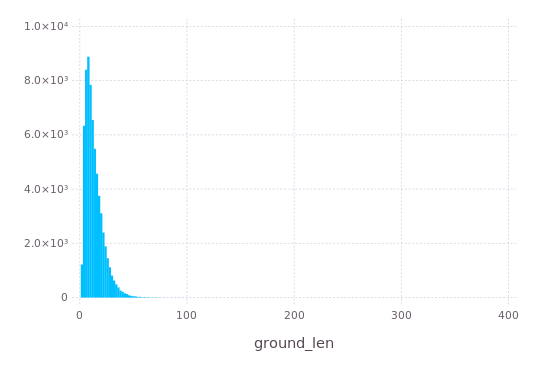

Mean:         12.729011
Minimum:      1.000000
1st Quartile: 7.000000
Median:       11.000000
3rd Quartile: 17.000000
Maximum:      246.000000


In [19]:
bag_res[:ground_len] |> describe 
p=Gadfly.plot(bag_res, x="ground_len",  Geom.histogram)
#draw(PNG("brown_length_dist.png", 24cm, 6cm), p)

In [ ]:
##############################################
# ORDERED
########################################

In [ ]:
using PyCall
@pyimport nltk
@pyimport nltk.align.bleu_score as nltk_bleu

function bleu_score(candidate, reference)
    reference = reference |> collect
    candidate = candidate |> collect
    
    if reference==candidate #Perfect Match
        1.0
    else
        weights = [1,1,1,1]/4
        nltk_bleu.bleu(candidate,Any[reference], weights)
    end
end

In [ ]:
bleu_score(["the","comedy","of","manners","of","this","first","a","basis","is","performed","in","1892","."],
           ["this","is","the" ,"basis","of","a" ,"comedy" ,"of","manners","first","performed","in","1892", "."]
)

In [ ]:
immutable OrderRecord{T}
    reference::Vector{T}
    actual::Vector{T}
    prob::Float64
    time::Float64
    status::Symbol
end

In [ ]:
function load_ordering_results(path, keys)
    blocked_records = Dict{Int,Any}([key=>load(path,string(key)) for key in keys])
    @pipe blocked_records |> flatten_blocked_records |> map(r->OrderRecord(r...),_)
end

books_0_001 = load_ordering_results("results/ordered/books_corpus_0.001_of_test_glove300.jld", 1:100)
books_0_001_oracle = load_ordering_results("results/ordered/books_corpus_0.001_of_test_oracle.jld", 1:100)

In [ ]:
attempted_only{T<:OrderRecord}(recs::Vector{T}) = filter(r->r.status!=:NotAttempted, recs)
feasible_only{T<:OrderRecord}(recs::Vector{T}) = filter(r->r.status!=:Infeasible, recs)


In [ ]:
function exact_match(rec::OrderRecord)
    rec.reference == rec.actual
end
function bleu_score(rec::OrderRecord)
    bleu_score( rec.actual, rec.reference)
end

In [ ]:
function get_ordering_res(;datas...)
    @pz datas
    ordering_res = DataFrame(Models=map(kw->kw[1],datas))
    
    methods = [
        (:Time_taken, data -> mean(map(r->r.time , data|> attempted_only))),
        (:BLEU_Score, data ->     mean(map(bleu_score,  data|> attempted_only))),
        (:Exact_Matches, data ->  mean(map(exact_match, data|> attempted_only))),
        (:Feasible, data ->     mean(map(r->r.status==:Optimal, data|> attempted_only))),
        (:Exact_Matches_Feasible_only, data ->  mean(map(exact_match, data|> attempted_only |>feasible_only))),
        (:BLEU_Score_feasible_only, data ->     mean(map(bleu_score,  data|> attempted_only |>feasible_only) )),
    ]
    
    for (method, fn) in methods
        ordering_res[method]=[fn(data) for (model, data) in datas]
    end
    ordering_res
end

ordering_res = get_ordering_res(books_0_001=books_0_001, books_0_001_oracle=books_0_001_oracle)
round_tbl(ordering_res)

In [ ]:
function mean_by_length{T<:OrderRecord}(rater::Function, data::Vector{T})
    groups = groupby_value(r->length(r.reference), data) 
    @assert symdiff(keys(groups),1:length(groups))|> length ==0
    [mean(map(rater,groups[len])) for len in 1:length(groups)]
end
function get_instance_counts(data)
    groups = groupby_value(r->length(r.reference), data) 
    [length(groups[sent_len]) for sent_len in sort(collect(keys(groups)))]
end

function get_ordering_length_res(data)
    ordering_length_res = DataFrame(ground_length=1:maximum([length(r.reference) for r in data |> attempted_only]),
    Instances = get_instance_counts(data|> attempted_only),
    Time_taken = mean_by_length(r->r.time , data|> attempted_only),
    BLEU_Score    =  mean_by_length(bleu_score,  data|> attempted_only),
    Exact_Matches =  mean_by_length(exact_match, data|> attempted_only),    
    Feasible      =  mean_by_length(r->r.status==:Optimal, data|> attempted_only),
    Exact_Matches_Feasible_only =  mean_by_length(exact_match, data|> attempted_only |>feasible_only),
    BLEU_Score_feasible_only    =  mean_by_length(bleu_score,  data|> attempted_only |>feasible_only) 
    )
end
#writetable(OUTPUT_DIR*"ordering_scores.csv", ordering_res)
ordering_length_res = get_ordering_length_res(books_0_001)
round_tbl(ordering_length_res)

In [ ]:
ordering_length_res_oracle = get_ordering_length_res(books_0_001_oracle)
round_tbl(ordering_length_res_oracle)

In [ ]:
Gadfly.plot(ordering_length_res, x=:ground_length, y=:Exact_Matches)

In [ ]:
Gadfly.plot(ordering_length_res, x=:ground_length, y=:BLEU_Score)

In [ ]:
Gadfly.plot(ordering_length_res, x=:ground_length, y=:Time_taken)

In [ ]:
function cum_means(indexed_data::DataFrame, index_col=:ground_length, count_col=:Instances)
    @assert issorted(indexed_data[index_col])
    cum_data=DataFrame()
    cum_data[Symbol("max_"*string(index_col))] = indexed_data[index_col]
    cum_data[count_col] = cumsum(indexed_data[count_col])
    keep_cols = @pipe indexed_data.colindex |> keys |> collect |> filter(col->col∉[index_col, count_col], _) |> collect
    for col in keep_cols
        total_count = 0
        total_score = 0
        prev_index = 0 
        function cum(ii)
            @assert ii>prev_index
            score = indexed_data[ii,col]
            count = indexed_data[ii,count_col]
            total_score = (total_score*total_count+score*count)/(total_count+count)
            total_count+=count
            prev_index = ii
            return total_score
        end
        cum_data[col]= map(cum, 1:length(indexed_data[col]))
    end
    cum_data
end
    

In [ ]:
cum_means(ordering_length_res)

In [ ]:
"results/bags/"

In [ ]:
delete!()

In [ ]:
########

In [ ]:
fold_indexes=load("brown_glove_folds.jld","fold_indexes");

In [ ]:
function fold(data, fold_indexes)
    ret = Dict()
    for (fold_number,fold_iis) in enumerate(fold_indexes)
        ret["fold_$(fold_number)"] = data[fold_iis]
    end
    ret
end

In [ ]:
jaccard_folds_300 = fold(bag_res[:glove300_jaccard], fold_indexes)

In [ ]:
[jaccard_folds_300["fold_6"] bleu_scores300[1]]

In [ ]:
get_bleu_score(folds300,  count_give_ups=true, count_nonattepts=true);